In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import re
import html
import unicodedata
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer  
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping


In [ ]:
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
train_df.sample().T

,3078
id,4415
keyword,electrocute
location,NaN
text,Electric vs Gas brewing (not wanting to electrocute myself) question http://t.co/26oo0fcL53
target,0


In [ ]:
train_df['text'][0:10]

0                                                                    Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1                                                                                                   Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3                                                                        13,000 people receive #wildfires evacuation orders in California 
4                                                 Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
5                           #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
6                                          #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
7                          

## Word Tokenization

In [ ]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()



def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
    return word_tokenize(text)

def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem ovocar lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
stop_words = stopwords.words('english')

In [ ]:
train_normalized = train_df['text'].apply(normalize_text).to_list()
test_normalized = test_df['text'].apply(normalize_text).to_list()

In [ ]:
labels = train_df['target'].values.astype('float32')

In [ ]:
vocab_sz = 1000
tok = Tokenizer(num_words=vocab_sz,oov_token='UNK')
tok.fit_on_texts(train_normalized + test_normalized)

In [ ]:
len(tok.word_index)

24919

In [ ]:
# Extract binary BoW features
train = tok.texts_to_matrix(train_normalized, mode='binary')
test = tok.texts_to_matrix(test_normalized, mode='binary')

In [ ]:
print(train.shape)
print(labels.shape)
print(test.shape)

(7613, 1000)
(7613,)
(3263, 1000)


## Train Test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train, labels, test_size=0.15, random_state=42)

## Model

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(vocab_sz,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                16016     
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 16,305
Trainable params: 16,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/20
13/13 [==============================] - 4s 19ms/step - loss: 0.6788 - binary_accuracy: 0.6364 - val_loss: 0.6620 - val_binary_accuracy: 0.6961
Epoch 2/20
13/13 [==============================] - 0s 6ms/step - loss: 0.6396 - binary_accuracy: 0.7407 - val_loss: 0.6245 - val_binary_accuracy: 0.7478
Epoch 3/20
13/13 [==============================] - 0s 7ms/step - loss: 0.5924 - binary_accuracy: 0.7866 - val_loss: 0.5835 - val_binary_accuracy: 0.7636
Epoch 4/20
13/13 [==============================] - 0s 7ms/step - loss: 0.5443 - binary_accuracy: 0.8039 - val_loss: 0.5460 - val_binary_accuracy: 0.7732
Epoch 5/20
13/13 [==============================] - 0s 6ms/step - loss: 0.5015 - binary_accuracy: 0.8139 - val_loss: 0.5161 - val_binary_accuracy: 0.7802
Epoch 6/20
13/13 [==============================] - 0s 6ms/step - loss: 0.4664 - binary_accuracy: 0.8198 - val_loss: 0.4949 - val_binary_accuracy: 0.7837
Epoch 7/20
13/13 [==============================] - 0s 6ms/step - loss: 0.4

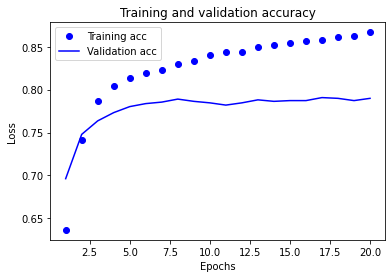

In [ ]:
history_dict = history.history
history_dict.keys()

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

epochs = range(1, len(acc) + 1)

plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# LSTM

In [ ]:
vocab_sz = 1000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
texts = train_normalized + test_normalized
tok.fit_on_texts(texts)

In [ ]:
train = tok.texts_to_sequences(train_normalized)
test = tok.texts_to_sequences(test_normalized)
# y_train = np.asarray(trn_labels).astype('float32')
# y_test = np.asarray(tst_labels).astype('float32')

Mean: 71


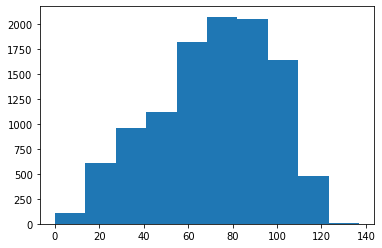

In [ ]:
length_distribution = [len(t) for t in texts]
mean_len = int(sum(length_distribution)/len(length_distribution))
plt.hist(length_distribution)

print('Mean:', mean_len)

In [ ]:
def pad_seq(seq, length):  
    return np.array(pad_sequences(seq, maxlen=length, padding='post', truncating='post'))

In [ ]:
train = pad_seq(train, mean_len)
test = pad_seq(test, mean_len)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train, labels, test_size=0.15, random_state=42)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM


embedding_size = 100

# Model 1: Simple LSTM, with Embedding mask_zero
model = Sequential()
model.add(Embedding(vocab_sz+1, embedding_size, mask_zero=True, input_length=mean_len))
model.add(LSTM(100, dropout=0.4))
model.add(Dense(1, activation='sigmoid'))



model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 71, 100)           100100    
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 180,601
Trainable params: 180,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
'''
# Mount GDrive
from google.colab import drive
drive.mount('/content/gdrive')
gdrive_path = 'gdrive/My Drive/Colab Notebooks/DL NLP Course'

from keras.callbacks import ModelCheckpoint, Callback
model_name = 'basic'
filepath = os.path.join(gdrive_path, 'imdb_lstm_' + model_name + '.h5')
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
'''
checkpoint = EarlyStopping(monitor='val_accuracy', mode='max')
callbacks_lst = [checkpoint]


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

callbacks_lst = [checkpoint]
# Training
batch_size = 256
epochs = 20
print('Train...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,          
          validation_data=(X_val, y_val),
          #validation_split=0.2,
          callbacks=callbacks_lst
                   )

history_dict = history.history
history_dict.keys()

Train...
Epoch 1/20
26/26 [==============================] - 9s 69ms/step - loss: 0.6739 - accuracy: 0.5953 - val_loss: 0.6400 - val_accuracy: 0.7172
Epoch 2/20
26/26 [==============================] - 0s 12ms/step - loss: 0.5264 - accuracy: 0.7833 - val_loss: 0.4914 - val_accuracy: 0.7767


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# Bi-directional LSTM

In [ ]:
model = Sequential()
model.add(Embedding(vocab_sz+1, embedding_size, mask_zero=True, input_length=mean_len))
model.add(layers.Bidirectional(LSTM(100, dropout=0.5)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,          
          validation_data=(X_val, y_val),
          #validation_split=0.2,
#           callbacks=callbacks_lst
                   )

Epoch 1/20
26/26 [==============================] - 11s 112ms/step - loss: 0.6659 - accuracy: 0.6027 - val_loss: 0.5843 - val_accuracy: 0.7268
Epoch 2/20
26/26 [==============================] - 0s 18ms/step - loss: 0.4922 - accuracy: 0.7870 - val_loss: 0.4774 - val_accuracy: 0.7881
Epoch 3/20
26/26 [==============================] - 0s 17ms/step - loss: 0.4154 - accuracy: 0.8193 - val_loss: 0.4797 - val_accuracy: 0.7846
Epoch 4/20
26/26 [==============================] - 0s 18ms/step - loss: 0.3889 - accuracy: 0.8283 - val_loss: 0.4829 - val_accuracy: 0.7837
Epoch 5/20
26/26 [==============================] - 0s 17ms/step - loss: 0.3763 - accuracy: 0.8346 - val_loss: 0.4812 - val_accuracy: 0.7750
Epoch 6/20
26/26 [==============================] - 0s 17ms/step - loss: 0.3650 - accuracy: 0.8401 - val_loss: 0.5073 - val_accuracy: 0.7662
Epoch 7/20
26/26 [==============================] - 0s 17ms/step - loss: 0.3539 - accuracy: 0.8444 - val_loss: 0.5226 - val_accuracy: 0.7802
Epoch 8/20


# GRU

In [ ]:
model = Sequential()
model.add(Embedding(vocab_sz+1, embedding_size, mask_zero=True, input_length=mean_len))
model.add(layers.Bidirectional(layers.GRU(100)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,          
          validation_data=(X_val, y_val),
          #validation_split=0.2,
#           callbacks=callbacks_lst
                   )

Epoch 1/20
26/26 [==============================] - 10s 123ms/step - loss: 0.6605 - accuracy: 0.6045 - val_loss: 0.5986 - val_accuracy: 0.7233
Epoch 2/20
26/26 [==============================] - 0s 17ms/step - loss: 0.4826 - accuracy: 0.7861 - val_loss: 0.4828 - val_accuracy: 0.7828
Epoch 3/20
26/26 [==============================] - 0s 15ms/step - loss: 0.3988 - accuracy: 0.8251 - val_loss: 0.4882 - val_accuracy: 0.7863
Epoch 4/20
26/26 [==============================] - 0s 15ms/step - loss: 0.3696 - accuracy: 0.8340 - val_loss: 0.5066 - val_accuracy: 0.7802
Epoch 5/20
26/26 [==============================] - 0s 16ms/step - loss: 0.3538 - accuracy: 0.8413 - val_loss: 0.5038 - val_accuracy: 0.7837
Epoch 6/20
26/26 [==============================] - 0s 16ms/step - loss: 0.3389 - accuracy: 0.8469 - val_loss: 0.5164 - val_accuracy: 0.7715
Epoch 7/20
26/26 [==============================] - 0s 16ms/step - loss: 0.3255 - accuracy: 0.8581 - val_loss: 0.5289 - val_accuracy: 0.7697
Epoch 8/20
